[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap10/cap10-main.ipynb) 

# Capítulo 10 - Introdução à Família Actor-Critic


## Configurações Iniciais

In [ ]:
import sys
from IPython.display import clear_output

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install swig
    !pip install gymnasium[box2d]

    # para salvar videos
    #!apt-get install -y ffmpeg xvfb x11-utils

    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

    #clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

clear_output()

In [ ]:
import gymnasium as gym
import numpy as np

from util.experiments import repeated_exec
from util.plot import plot_result, plot_multiple_results
from util.notebook import display_videos_from_path

from cap09.models_torch_pg import PolicyModelPG, PolicyModelPGWithExploration, ValueModel 
from cap09.models_torch_pg import test_policy

## 1 - Rodando o Vanilla Actor-Critic de 1 passo

In [ ]:
from cap10.actor_critic import run_vanilla_actor_critic

In [ ]:
ENV_NAME, rmax = "CartPole-v1", 500
#ENV_NAME, rmax = "Acrobot-v1", 0
#ENV_NAME, rmax = "LunarLander-v2", 150
#ENV_NAME, rmax = "MountainCar-v0", -20

NUM_STEPS = 10_000
GAMMA    = 0.99

env = gym.make(ENV_NAME)
inputs = env.observation_space.shape[0]
outputs = env.action_space.n
policy1 = PolicyModelPG(inputs, [256,256], outputs, lr=4e-5)
v_model = ValueModel(inputs, [256,128], lr=1e-4)

returns1, policy = run_vanilla_actor_critic(env, NUM_STEPS, GAMMA, initial_policy=policy1, initial_v_model=v_model)
clear_output()

print("Últimos episódios do treinamento: media =", np.mean(returns1[-20:]), ", desvio padrao =", np.std(returns1[-20:]))

In [ ]:
# Exibe um gráfico episódios x retornos (não descontados)
plot_result(returns1, rmax, x_axis='steps')

In [ ]:
# Roda alguns episódigos com o modelo e salva os vídeos em arquivos
env1 = gym.make(ENV_NAME, render_mode="rgb_array")
video_env=gym.wrappers.RecordVideo(env1, "./vid-ac-basic", episode_trigger=(lambda ep : True), video_length=3_000)
test_policy(video_env, policy1, False, 3)
video_env.close()

In [ ]:
display_videos_from_path('./vid-ac-basic')

## 2 - Rodando o Vanilla Actor-Critic de n Passos

In [ ]:
from cap10.actor_critic_nstep import run_vanilla_actor_critic_nstep

In [ ]:
ENV_NAME, rmax = "CartPole-v1", 500
#ENV_NAME, rmax = "Acrobot-v1", 0
#ENV_NAME, rmax = "LunarLander-v2", 150
#ENV_NAME, rmax = "MountainCar-v0", -20

# ATENÇÃO para a mudança: agora, o critério de parada é pela quantidade de passos
# e não pela quantidade de episódios (agora estamos seguindo o padrão da área)
NUM_STEPS = 20_000
GAMMA     = 0.99
NSTEPS    = 16
#EXPLORATION_FACTOR = 0.01  # no CartPole, funciona bem com 0.0

env = gym.make(ENV_NAME)
inputs = env.observation_space.shape[0]
outputs = env.action_space.n

#policy2 = PolicyModelPGWithExploration(inputs, [256, 256], outputs, exploration_factor=EXPLORATION_FACTOR, lr=3e-5)
policy2 = PolicyModelPG(inputs, [256, 256], outputs, lr=4e-5) #5e-5
v_model = ValueModel(inputs, [256,32], lr=8e-5) #1e-4

returns2, policy2 = run_vanilla_actor_critic_nstep(env, NUM_STEPS, GAMMA, nsteps=NSTEPS, initial_policy=policy2, initial_v_model=v_model)
clear_output()

print("Últimos episódios do treinamento: media =", np.mean(returns2[-20:]), ", desvio padrao =", np.std(returns2[-20:]))

In [ ]:
# Exibe um gráfico episódios x retornos (não descontados)
plot_result(returns2, rmax, x_axis='steps')

In [ ]:
# Roda alguns episódigos com o modelo e salva os vídeos em arquivos
env2 = gym.make(ENV_NAME, render_mode="rgb_array")
video_env = gym.wrappers.RecordVideo(env2, "./vid-ac-nsteps", episode_trigger=(lambda ep : True), video_length=3_000)
test_policy(video_env, policy2, False, 3)
video_env.close()

In [ ]:
display_videos_from_path('./vid-ac-nsteps')

## 3 - Experimentos


### 3.1 Comparações Básicas


In [ ]:
AUTO_LOAD = True

In [24]:
env = gym.make("CartPole-v1")
TRAINING_STEPS = 15_000

results3 = []

results3.append( repeated_exec(3, f"VAC 1 step", run_vanilla_actor_critic, env, TRAINING_STEPS, gamma=0.99, verbose=False, auto_load=AUTO_LOAD) )
clear_output()

results3.append( repeated_exec(3, f"VAC 2 steps", run_vanilla_actor_critic_nstep, env, TRAINING_STEPS, gamma=0.99, nsteps=2, verbose=False, auto_load=AUTO_LOAD) )
clear_output()

results3.append( repeated_exec(3, f"VAC 16 steps", run_vanilla_actor_critic_nstep, env, TRAINING_STEPS, gamma=0.99, nsteps=16, verbose=False, auto_load=AUTO_LOAD) )
clear_output()

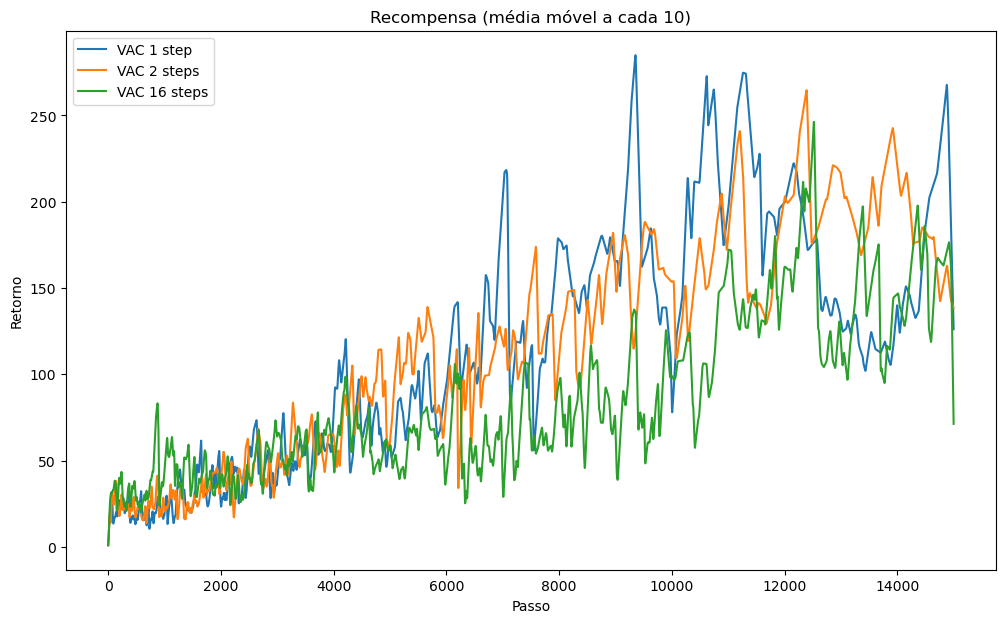

In [25]:
plot_multiple_results(results3, x_axis='step', cumulative=False, x_log_scale=False)

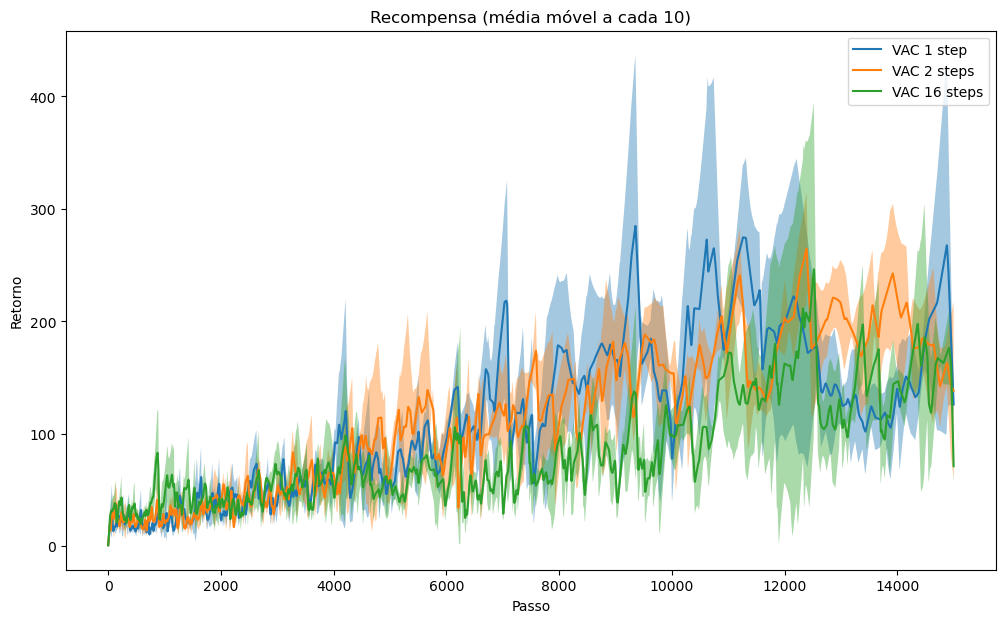

In [26]:
plot_multiple_results(results3, x_axis='step', cumulative=False, plot_stddev=True)

**Desafio simples**: alterar o código do *Reinforce-Adv* para permitir a comparação com os métodos actor-critic?